In [1]:
# Specification
# https://github.com/SBRG/bigg_models/wiki/BiGG-Models-ID-Specification-and-Guidelines

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import json

In [3]:
with open('../data/iEC1344_C.json', 'r') as file:
    models = json.loads(file.read())

## Data Inspection

In [4]:
type(models)

dict

In [5]:
len(models)

6

In [6]:
models.keys()

dict_keys(['metabolites', 'reactions', 'genes', 'id', 'compartments', 'version'])

In [7]:
models['id']

'iEC1344_C'

In [8]:
models['version']

'1'

In [9]:
models['compartments']

{'c': 'cytosol', 'e': 'extracellular space', 'p': 'periplasm'}

In [10]:
models['reactions'][:2]

[{'id': 'EX_cm_e',
  'name': 'Chloramphenicol exchange',
  'metabolites': {'cm_e': -1.0},
  'lower_bound': 0.0,
  'upper_bound': 1000.0,
  'gene_reaction_rule': '',
  'subsystem': 'Extracellular exchange',
  'notes': {'original_bigg_ids': ['EX_cm_LPAREN_e_RPAREN_']},
  'annotation': {'bigg.reaction': ['EX_cm_e'],
   'metanetx.reaction': ['MNXR96808'],
   'rhea': ['35288', '35290', '35287', '35289'],
   'sbo': 'SBO:0000627'}},
 {'id': 'EX_cmp_e',
  'name': 'CMP exchange',
  'metabolites': {'cmp_e': -1.0},
  'lower_bound': 0.0,
  'upper_bound': 1000.0,
  'gene_reaction_rule': '',
  'subsystem': 'Extracellular exchange',
  'notes': {'original_bigg_ids': ['EX_cmp_LPAREN_e_RPAREN_']},
  'annotation': {'bigg.reaction': ['EX_cmp_e'],
   'metanetx.reaction': ['MNXR96806'],
   'sbo': 'SBO:0000627',
   'seed.reaction': ['rxn08236', 'rxn09776']}}]

In [11]:
models['metabolites'][:2]

[{'id': 'gly_c',
  'name': 'Glycine',
  'compartment': 'c',
  'formula': 'C2H5NO2',
  'notes': {'original_bigg_ids': ['gly_c']},
  'annotation': {'bigg.metabolite': ['gly'],
   'biocyc': ['META:GLY'],
   'chebi': ['CHEBI:32508',
    'CHEBI:32507',
    'CHEBI:15428',
    'CHEBI:42964',
    'CHEBI:14344',
    'CHEBI:24368',
    'CHEBI:10792',
    'CHEBI:5460',
    'CHEBI:57305'],
   'envipath': ['32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/19441357-44af-48e1-b5ac-0e48c8dcbb87',
    '650babc9-9d68-4b73-9332-11972ca26f7b/compound/870d7ca5-6659-40eb-8b5d-858bd29cddaa'],
   'hmdb': ['HMDB00123'],
   'inchi_key': ['DHMQDGOQFOQNFH-UHFFFAOYSA-N'],
   'kegg.compound': ['C00037'],
   'kegg.drug': ['D00011'],
   'metanetx.chemical': ['MNXM29'],
   'reactome.compound': ['29424', '193446', '113545', '159549', '266029'],
   'sabiork': ['66'],
   'sbo': 'SBO:0000247',
   'seed.compound': ['cpd00033']}},
 {'id': 'nadp_c',
  'name': 'Nicotinamide adenine dinucleotide phosphate',
  'compartment': 'c',


## 'gene reaction rule' in 'reactions'

In [12]:
for i, reaction in enumerate(models['reactions']):
    if i < 60:
        print(reaction['gene_reaction_rule'])
    else:
        break
        

From above, we see that some reactions are ruled by some genes, and some reactions are not ruled by any gene.

## look at a spefic reaction and compare data to its web infomation

In [13]:
# http://bigg.ucsd.edu/models/iND750/reactions/13BGH
for reaction in models['reactions']:
    if reaction['id'] == '13BGH':
        print(reaction)

The useful attribute here is *'metabolites'*, 

In [14]:
for gene in models['genes']:
    if gene['id'] == 'YGR282C':
        print(gene)

## Data Preparation

In [15]:
# step 1: find one gene
# step 2: find the reactions which are ruled by this gene
# step 3: find the substrate (< 0) and products (> 0) of one of these reactions. Repeat for all reactions ruled by this gene.
# step 4: repeat above steps for all genes -- every gene has a list of substrates and products.
# step 5: if a product of gene A is a substrate of gene B, then gene A and gene B has a connection

In [23]:
genes = {}
inorganics = []
for gene in models['genes']:
    genes[gene['id']] = {}
    genes[gene['id']]['reactions'] = []
    genes[gene['id']]['substrates'] = []
    genes[gene['id']]['products'] = []
    for reaction in models['reactions']:
        if gene['id'] in reaction['gene_reaction_rule'] and gene['id'] not in genes[gene['id']]['reactions']:
            genes[gene['id']]['reactions'].append(reaction['id'])
            for metabolite, v in reaction['metabolites'].items():
                for m in models['metabolites']:
                    if m['id'] == metabolite:
                        # exclude inorganic metabolites
                        try:
                            if 'C' in m['formula'] and m['formula'] not in ['CO2', 'CO', 'C']:
                                if v > 0 and metabolite not in genes[gene['id']]['products']:
                                    genes[gene['id']]['products'].append(metabolite)
                                if v < 0 and metabolite not in genes[gene['id']]['substrates']:
                                    genes[gene['id']]['substrates'].append(metabolite)
                            elif metabolite not in inorganics:
                                inorganics.append(metabolite)
                            else:
                                break
                        except KeyError:
                            print(m)
#                     if v == 1 and metabolite not in genes[gene['id']]['products']:
#                         genes[gene['id']]['products'].append(metabolite)
#                     if v == -1 and metabolite not in genes[gene['id']]['substrates']:
#                         genes[gene['id']]['substrates'].append(metabolite)
                            
for k0, v0 in genes.items():
    v0['links'] = []
    for product in v0['products']:
        for k1, v1 in genes.items():
            if k1 != k0 and product in v1['substrates']:
                v0['links'].append(k1)
                

{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'co

{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'compartment': 'p', 'notes': {'original_bigg_ids': ['LptA_p']}, 'annotation': {'bigg.metabolite': ['LptA'], 'metanetx.chemical': ['MNXM148424'], 'sbo': 'SBO:0000247'}}
{'id': 'LptA_p', 'name': 'Periplasmic lipid A binding protein ', 'co

In [24]:
inorganics

['co2_e',
 'co2_p',
 'fe2_e',
 'fe2_p',
 'fe3_e',
 'fe3_p',
 'aso3_e',
 'aso3_p',
 'h2o2_e',
 'h2o2_p',
 'h2o_e',
 'h2o_p',
 'h2s_e',
 'h2s_p',
 'h2_e',
 'h2_p',
 'h_e',
 'h_p',
 'hg2_e',
 'hg2_p',
 'k_e',
 'k_p',
 'mg2_e',
 'mg2_p',
 'mn2_e',
 'mn2_p',
 'mobd_e',
 'mobd_p',
 'n2o_e',
 'n2o_p',
 'na1_e',
 'na1_p',
 'no3_e',
 'no3_p',
 'no_e',
 'no_p',
 'nh4_e',
 'nh4_p',
 'ni2_e',
 'ni2_p',
 'no2_e',
 'no2_p',
 'o2s_e',
 'o2s_p',
 'o2_e',
 'o2_p',
 'pi_e',
 'pi_p',
 'sel_e',
 'sel_p',
 'slnt_e',
 'slnt_p',
 'so2_e',
 'so2_p',
 'so3_e',
 'so3_p',
 'so4_e',
 'so4_p',
 'tsul_e',
 'tsul_p',
 'tungs_e',
 'tungs_p',
 'zn2_e',
 'zn2_p',
 'ppt_e',
 'ppt_p',
 'ppi_c',
 'co2_c',
 'h_c',
 'h2o_c',
 'pi_c',
 'nh4_c',
 'no2_c',
 'no3_c',
 'fe2_c',
 'o2_c',
 'h2o2_c',
 '3fe4s_c',
 '4fe4s_c',
 'fe3_c',
 'n2o_c',
 'no_c',
 'h2s_c',
 'h2_c',
 'so2_c',
 'k_c',
 'o6a4colipa_LptA_p',
 'o6a4colipa_p',
 'apoACP_c',
 'na1_c',
 'iscs_c',
 'iscssh_c',
 'trdox_c',
 'trdrd_c',
 'ag_c',
 'ag_e',
 'dsbdox_c',
 'ds

In [25]:
df = pd.DataFrame.from_dict(genes).T
df

,reactions,substrates,products,links
locus_3116,"[12PPDRtex, 12PPDStex, 23CAMPtex, 23CCMPtex, 2...","[12ppd__R_e, 12ppd__S_e, 23camp_e, 23ccmp_e, 2...","[12ppd__R_p, 12ppd__S_p, 23camp_p, 23ccmp_p, 2...","[locus_513, locus_51, locus_513, locus_51, loc..."
locus_1413,"[12PPDRtex, 12PPDStex, 23CAMPtex, 23CCMPtex, 2...","[12ppd__R_e, 12ppd__S_e, 23camp_e, 23ccmp_e, 2...","[12ppd__R_p, 12ppd__S_p, 23camp_p, 23ccmp_p, 2...","[locus_513, locus_51, locus_513, locus_51, loc..."
locus_274,"[12PPDRtex, 12PPDStex, 23CAMPtex, 23CCMPtex, 2...","[12ppd__R_e, 12ppd__S_e, 23camp_e, 23ccmp_e, 2...","[12ppd__R_p, 12ppd__S_p, 23camp_p, 23ccmp_p, 2...","[locus_513, locus_51, locus_513, locus_51, loc..."
locus_4249,"[12PPDRtex, 12PPDStex, 23CAMPtex, 23CCMPtex, 2...","[12ppd__R_e, 12ppd__S_e, 23camp_e, 23ccmp_e, 2...","[12ppd__R_p, 12ppd__S_p, 23camp_p, 23ccmp_p, 2...","[locus_513, locus_51, locus_513, locus_51, loc..."
locus_4366,"[14GLUCANtexi, GLCtex_copy2, MALTHXtexi, MALTP...","[14glucan_e, glc__D_e, malthx_e, maltpt_e, mal...","[14glucan_p, glc__D_p, malthx_p, maltpt_p, mal...","[locus_3615, locus_36, locus_1507, locus_1505,..."
...,...,...,...,...
locus_4214,[ASNO],"[glu__L_c, nagg_c]","[gln__L_c, naggn_c]","[locus_3945, locus_2445, locus_3589, locus_586..."
locus_2699,[PYRDC],[pyr_c],[acald_c],"[locus_3535, locus_3046, locus_29, locus_2915,..."
locus_3025,[HPA3MOFAD],"[34dhpha_c, fad_c]","[4hphac_c, fadh2_c]","[locus_300, locus_28, locus_2845, locus_279, l..."
locus_2906,[SUCP],[sucr_c],"[fru_c, g1p_c]","[locus_22, locus_2213, locus_3539, locus_2776,..."


In [27]:
df1 = pd.DataFrame({'index':df.index.repeat(df.links.str.len()), 'links':df.links.sum()})
df1

,index,links
0,locus_3116,locus_513
1,locus_3116,locus_51
2,locus_3116,locus_513
3,locus_3116,locus_51
4,locus_3116,locus_513
...,...,...
78278,locus_2906,locus_23
78279,locus_2906,locus_31
78280,locus_3440,locus_34
78281,locus_3440,locus_3449


In [28]:
# show genes having no links
print(df.loc[df['links'].str.len() == 0])

                       reactions               substrates  \
locus_3615             [AAMYLpp]             [14glucan_p]   
locus_3496    [ACSERtpp, CYStpp]      [acser_c, cys__L_c]   
locus_4109    [ACSERtpp, CYStpp]      [acser_c, cys__L_c]   
locus_1245              [DHORTS]              [dhor__S_c]   
locus_1322              [DHPTPE]                 [ahdt_c]   
...                          ...                      ...   
locus_997       [CMLBL, DIEHLAC]      [4cnbt_c, trdiel_c]   
locus_2827      [CMLBL, DIEHLAC]      [4cnbt_c, trdiel_c]   
locus_2797               [DHXAN]         [cl_c, glyclt_c]   
locus_2820  [AMID, AMID5, AMID3]  [4gudbd_c, aa_c, iad_c]   
locus_443                [LYSAM]               [lys__L_c]   

                                   products links  
locus_3615                       [malthx_p]    []  
locus_3496              [acser_p, cys__L_p]    []  
locus_4109              [acser_p, cys__L_p]    []  
locus_1245                        [cbasp_c]    []  
locus_1

In [29]:
G = nx.from_pandas_edgelist(df=df1, source='index', target='links')

In [30]:
# get subgraphs
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [31]:
giant = max(connected_component_subgraphs(G), key=len)

In [32]:
giant.number_of_nodes()

1299

## Laplacian and Eigen

In [33]:
# Laplacian Matrix
L = nx.laplacian_matrix(giant, nodelist=sorted(giant.nodes())).astype(np.int64)
L.todense()

matrix([[182,  -1,   0, ...,   0,   0,   0],
        [ -1, 383,   0, ...,  -1,   0,   0],
        [  0,   0,  97, ...,  -1,   0,   0],
        ...,
        [  0,  -1,  -1, ..., 128,   0,   0],
        [  0,   0,   0, ...,   0,   7,  -1],
        [  0,   0,   0, ...,   0,  -1,  30]], dtype=int64)

In [34]:
eig = np.linalg.eig(L.todense())

## Plotting

In [35]:
def draw_sub(k, eig, G, layout, ccmap, vmin, vmax):
    i = np.argpartition(eig[0], k)[k]
    v = eig[1].real[:, i].T.tolist()[0]
    # node_color is the coefficient of eigenvectors 
    nx.draw(G, layout, node_size=100, node_color=v, edge_color="#cccccc", edgecolors='#000000', cmap=ccmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    sm = plt.cm.ScalarMappable(cmap=ccmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm)

In [36]:
def change_scale(eig):
    # smallest coefficient
    vmin = np.amin(eig[1])
    # largest coefficient
    vmax = np.amax(eig[1])
    if vmin*vmax < 0:
        v = max(abs(vmin), abs(vmax))
        vmin = -v
        vmax = v
    # if vmin and vmax have the same sign, the colorbar can't be symmetrical.
    return vmin, vmax

## Make Color Map

In [37]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
winter = cm.get_cmap('winter', 128)
autumn = cm.get_cmap('autumn_r', 128)

newcolors = np.vstack((winter(np.linspace(0, 1, 128)),
                       autumn(np.linspace(0, 1, 128))))
ccmap = ListedColormap(newcolors, name='OrangeBlue')

In [38]:
plt.rc('figure', figsize=(30, 30))
K = 5/np.sqrt(giant.order())
layout = nx.spring_layout(G, k=K, seed=3)

## Plot 1st, 2nd, 3rd smallest, and largest coefficient

C:\Users\zhouy\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


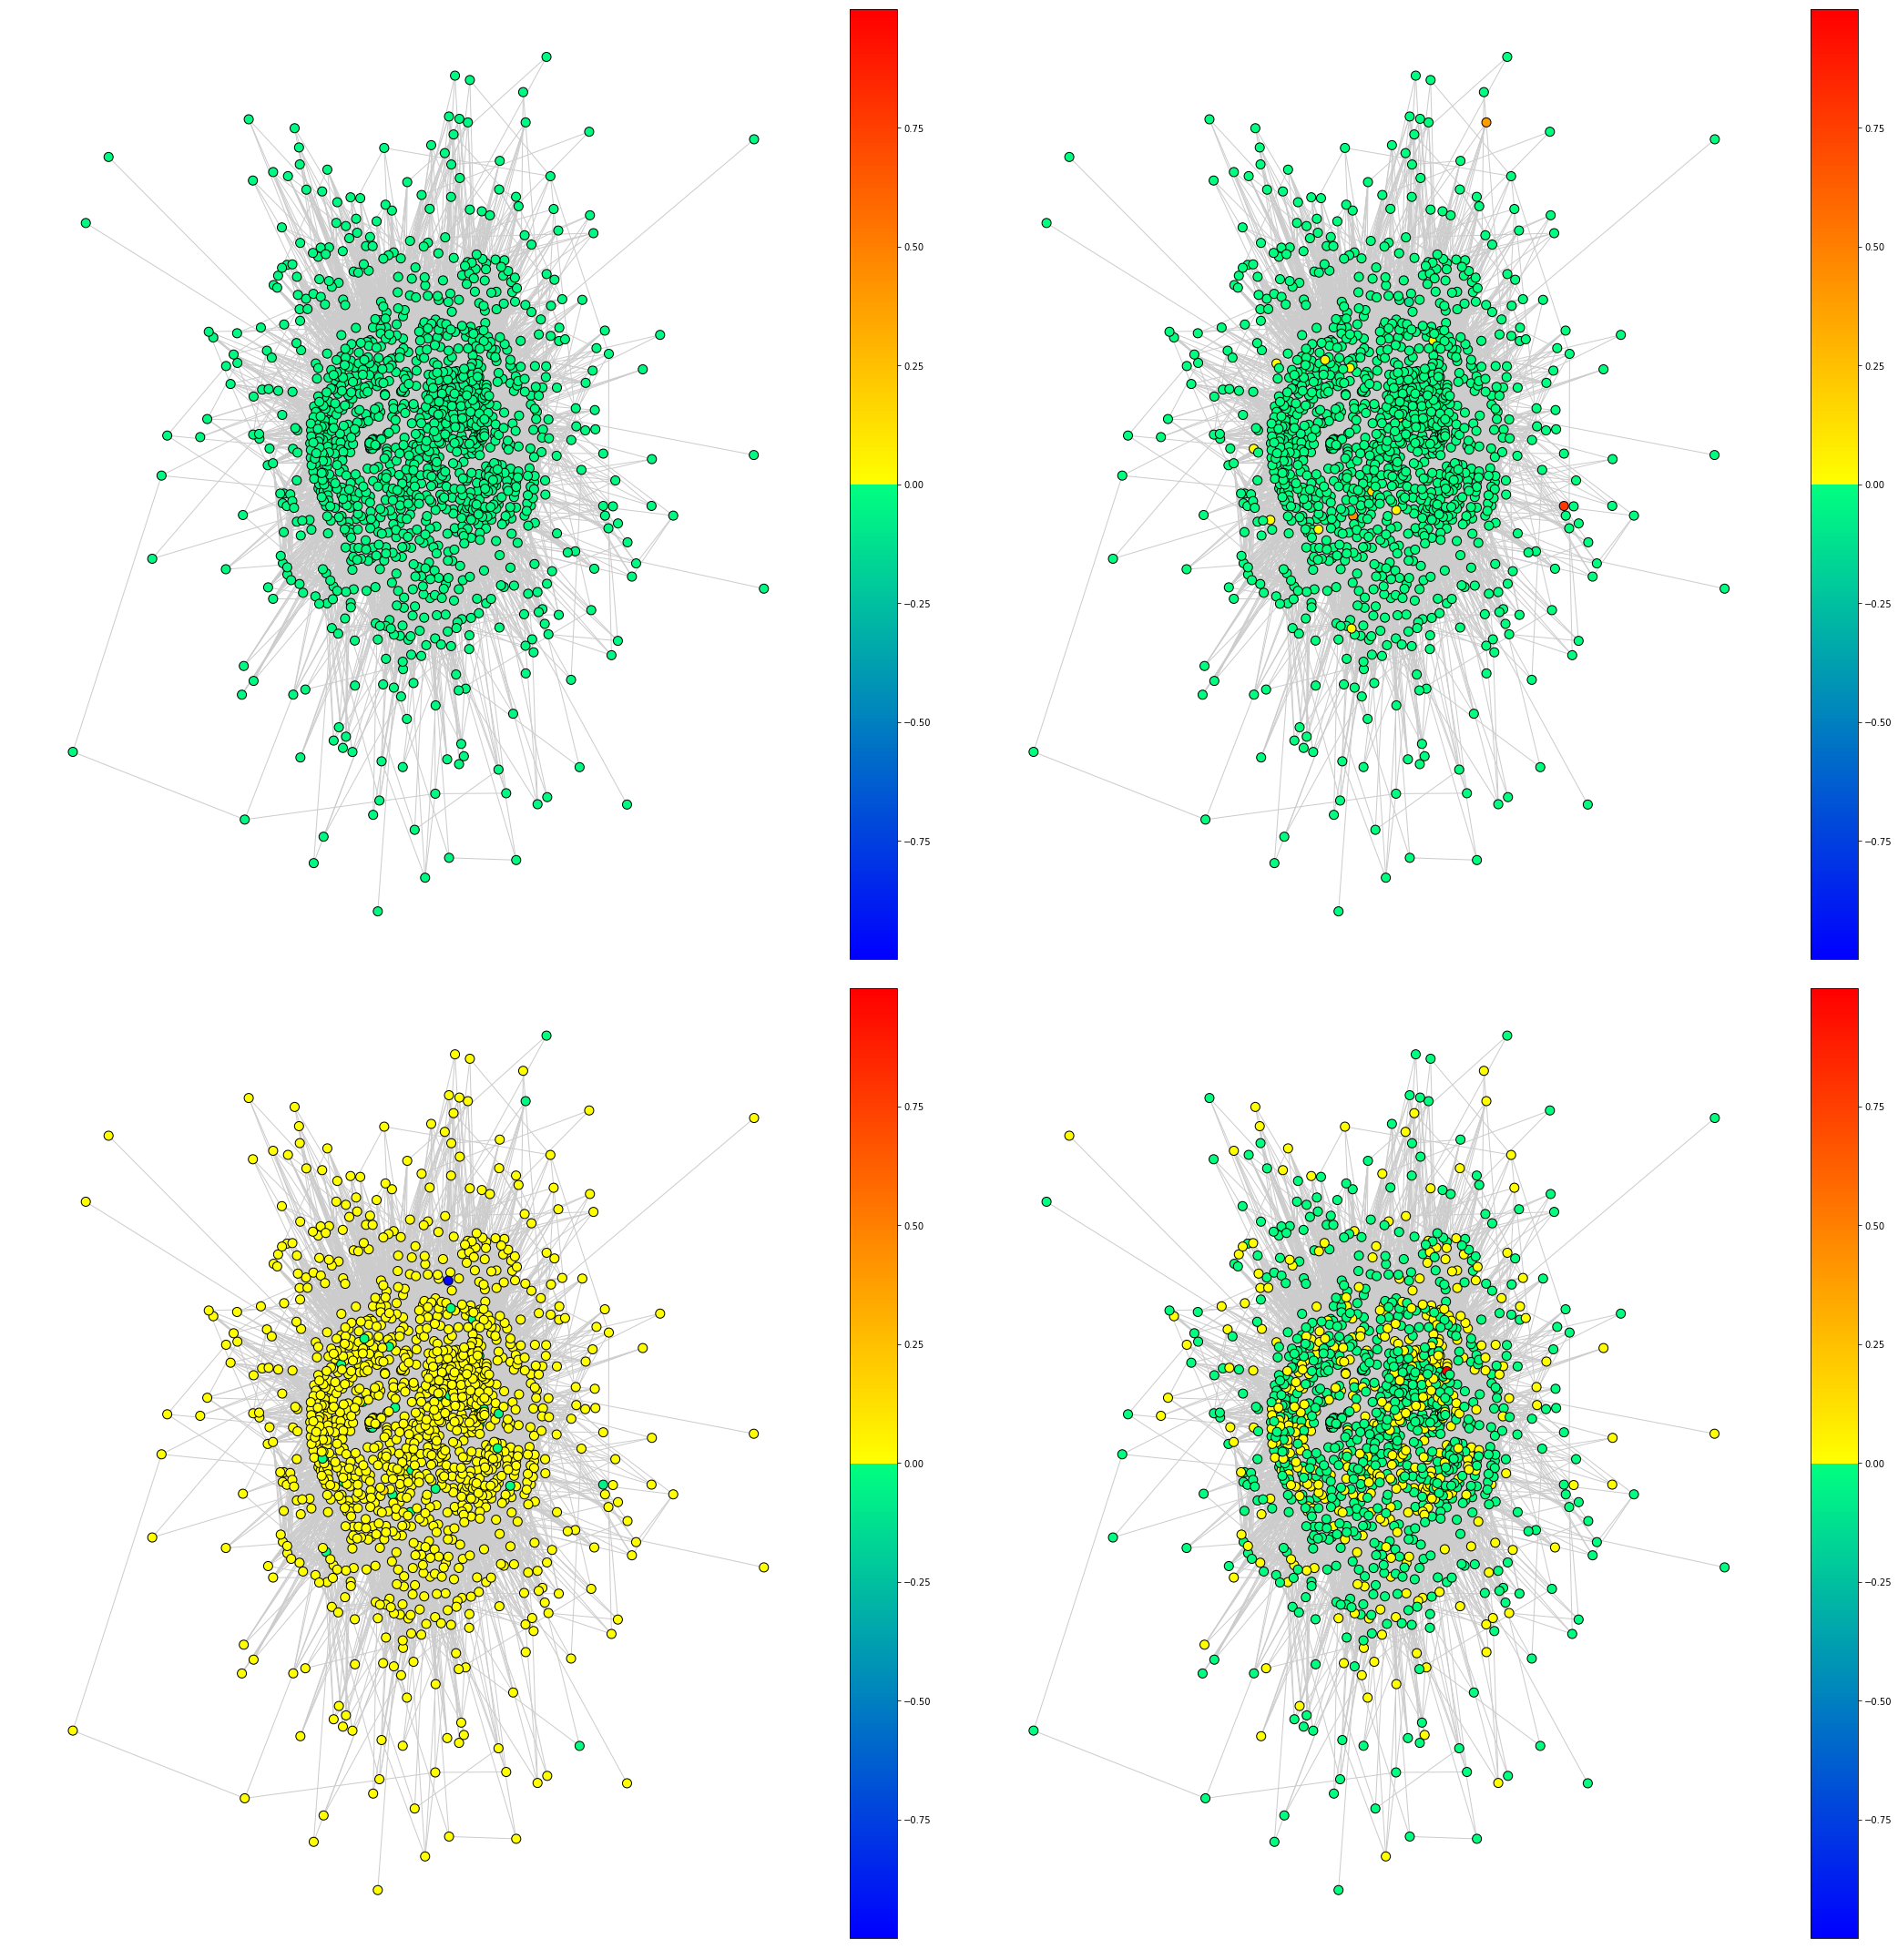

In [39]:
k_lst = [0, 1, 2, len(eig[0])-1]
vmin, vmax = change_scale(eig)
for i, k in enumerate(k_lst):
    plt.subplot(2,2,i+1)
    draw_sub(k, eig, giant, layout, ccmap, vmin, vmax)
plt.tight_layout()
plt.show()